In [1]:
%load_ext autoreload
%autoreload 2

In [13]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


In [39]:
import tensorflow as tf, pandas as pd

def parse_TFR_data_labelled(sample):
    tfrec_format = {
          'image'                        : tf.io.FixedLenFeature([], tf.string),
          'image_name'                   : tf.io.FixedLenFeature([], tf.string),
          #'patient_id'                   : tf.io.FixedLenFeature([], tf.int64),
          #'sex'                          : tf.io.FixedLenFeature([], tf.int64),
          #'age_approx'                   : tf.io.FixedLenFeature([], tf.int64),
          #'anatom_site_general_challenge': tf.io.FixedLenFeature([], tf.int64),
          #'diagnosis'                    : tf.io.FixedLenFeature([], tf.int64),
          'target'                       : tf.io.FixedLenFeature([], tf.int64)}
    example = tf.io.parse_single_example(sample, tfrec_format)
        
    #img = p['image']
    #target = p['target']

    return example

def decode_image(img , IMG_DIMS):
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img , [IMG_DIMS , IMG_DIMS])
    return img

In [ ]:
!git clone https://github.com/ARMargolis/melanoma-pytorch.git

In [107]:
import pandas as pd
from torchvision.transforms.functional import to_pil_image
from torch.utils.data import DataLoader
import pandas as pd 
import numpy as np
import torch
from torch import nn, sigmoid
from torch.nn import functional as F
from torch.utils import data

from PIL import Image, ImageOps
from torchvision import transforms, utils


default_device = 'cuda' if torch.cuda.is_available() else 'cpu'

class MelanomaDatasetCL(data.Dataset):
    # TODO initialize conv layers and fc layers in a particular way. Important for our experiment
    # TODO add cuda support
    
    def __init__(self, gcs_path, train, device = default_device, **specifications):
        """
        Initializes the dataset. Will use .tfrec files
        gcs_path (str): GCS path where images and labels are stored
        specifications (optional): any extra keyword args are stored in a dict. Can include:
            -transform
            -resolution: what size do we want to resize the images to? Square or rectangular?
        """
        
        #  Handle specifications
        if specifications:
            print('Specifications:')
            for key, value in specifications.items():
                print(key, ' : ', value)
            print('----------------------')
        #images generally are 1053x1872 coming in - will centercrop to 1000 x 1000
        self.initial_resolution = (1053,1872)
        if 'initial_resolution' in specifications:
            if isinstance(specifications['initial_resolution']):
                self.initial_resolution = specifications['initial_resolution']
            else:
                print('Invalid format for inital resolution. Give a tuple')
        # Set resolution of actual samples to feed into the model
        self.resolution = 244 # 1000 default

        # Figure out what transforms to use
        if 'transform' not in specifications:
            # If I didn't specify a transform
            if train:
                # if a training dataset
                self.transform = transforms.Compose(
                    [
                        transforms.Resize(self.initial_resolution),
                        transforms.CenterCrop(self.initial_resolution[0]), #get a square image
                        transforms.RandomResizedCrop(size=self.resolution, scale=(0.8, 1.0)),
                        transforms.RandomVerticalFlip(p=0.5),
                        transforms.RandomHorizontalFlip(p=0.5),
                        #transforms.RandomRotation(degrees=10, resample = Image.BICUBIC, expand = True),
                        #transforms.CenterCrop(self.resolution),
                        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
                        transforms.ToTensor(),
                        transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]) #Taken from overall dataset
                    ]
                )
            else:
                # if test
                self.transform = transforms.Compose(
                    [
                        transforms.Resize(self.initial_resolution),
                        transforms.CenterCrop(self.initial_resolution[0]), #get a square image
                        transforms.CenterCrop(self.resolution), 
                        transforms.ToTensor(),
                        transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
                    ]
                )
        else:
            if specifications['transform'] == None:
                # If I specifically specify no transform, then the only transform is to_tensor
                self.transform = transforms.functional.to_tensor #self.transform is a function
            else:
                # If I directly feed in a transform, use that
                self.transform = specifications['transform']

        self.gcs_path = gcs_path
        tfrec_dataset = tf.data.TFRecordDataset(gcs_path)
        tfrec_dataset_cache=tfrec_dataset.cache()
        tfrec_dataset_cache_map1=tfrec_dataset_cache.map(parse_TFR_data_labelled)
        self.data_iter=tfrec_dataset_cache_map1.as_numpy_iterator()
        self.label_df=pd.Series(tf.io.gfile.glob(gcs_path))

        self.device = device
    
    def __len__(self):
        return self.label_df.shape[0]

    def __getitem__(self, idx):
        """
            Get a single sample
            Want this method to be very fast, i.e. few or no if statements, etc.
        """
        #if torch.is_tensor(idx):
        #    idx = idx.tolist()
        
        next_data=next(self.data_iter)
        name=next_data['image_name']
        label=next_data['target']
        
        # get PIL image
        decoded_img=decode_image(next_data['image'],1024).numpy().astype(np.uint8)
        image = Image.fromarray(decoded_img)
        image = self.transform(image)
        image = image.to(self.device)

        return (image, torch.LongTensor([label]) )
    
    def display_sample(self, idx):
        pic, label = self.__getitem__(idx)
        pic = pic.to('cpu')
        pic = transforms.functional.to_pil_image(pic)
        print('----------------------\nlabel: ', label.cpu().numpy())
        # if not using in jupyter notebook context, show the image directly instead of returning it
        # pic.show()
        return pic

In [86]:
default_config = {
    'input_shape':(1,3,244,244),
    'n_classes':1, #binary classification
    'base_channels':3,
    'block_type':'basic',
    'depth':20, # depth should be two more than a multiple of six
    'device': 'cuda' if torch.cuda.is_available() else 'cpu'

}

# Credit for all code below goes to https://github.com/hysts/pytorch_resnet/blob/master/resnet.py
# The license of said project allows for reuse (commercial or otherwise), modification, and distribution of the code, without limitations

class MelanomaNet(nn.Module):
    def __init__(self, config=default_config):
        super(MelanomaNet, self).__init__()
        print(config)

        input_shape = config['input_shape']
        n_classes = config['n_classes']

        base_channels = config['base_channels']
        block_type = config['block_type']
        depth = config['depth']
        self.device = config['device']

        assert block_type in ['basic', 'bottleneck']
        if block_type == 'basic':
            print('block type: ', block_type)
            block = BasicBlock
            n_blocks_per_stage = (depth - 2) // 6
            print('blocks per stage: ', n_blocks_per_stage)
            assert n_blocks_per_stage * 6 + 2 == depth
        else:
            block = BottleneckBlock
            n_blocks_per_stage = (depth - 2) // 9
            assert n_blocks_per_stage * 9 + 2 == depth

        n_channels = [
            base_channels, base_channels * 2 * block.expansion,
            base_channels * 4 * block.expansion
        ]

        self.conv = nn.Conv2d(
            input_shape[1],
            n_channels[0],
            kernel_size=3,
            stride=1,
            padding=1,
            bias=False)
        self.bn = nn.BatchNorm2d(base_channels)

        self.stage1 = self._make_stage(
            n_channels[0], n_channels[0], n_blocks_per_stage, block, stride=1)
        self.stage2 = self._make_stage(
            n_channels[0], n_channels[1], n_blocks_per_stage, block, stride=2)
        self.stage3 = self._make_stage(
            n_channels[1], n_channels[2], n_blocks_per_stage, block, stride=2)

        # compute conv feature size
        with torch.no_grad():
            self.feature_size = self._forward_conv(
                torch.zeros(*input_shape)).view(-1).shape[0]

        self.fc = nn.Linear(self.feature_size, n_classes)

        # initialize weights
        #self.apply(initialize_weights)

        self.to(self.device)

    def _make_stage(self, in_channels, out_channels, n_blocks, block, stride):
        stage = nn.Sequential()
        for index in range(n_blocks):
            block_name = 'block{}'.format(index + 1)
            if index == 0:
                stage.add_module(
                    block_name, block(
                        in_channels, out_channels, stride=stride))
            else:
                stage.add_module(block_name,
                                 block(out_channels, out_channels, stride=1))
        return stage

    def _forward_conv(self, x):
        x = F.relu(self.bn(self.conv(x)), inplace=True)
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = F.adaptive_avg_pool2d(x, output_size=1)
        return x

    def forward(self, x):
        x = self._forward_conv(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    
    def predict(self, x, threshold=0.5):
        # predict 0 (benign) or 1 (malignant)
        model.eval()
        with torch.no_grad():
            a = self.forward(x)
            a = sigmoid(a)
            # Round to 0 or 1 by threshold. 
            # In a clinical setting, a false negative would probably be worse than 
            # a false positive so we would set the confidence threshold lower
            a = (a.detach().cpu().numpy() > threshold).astype(int)
            return a


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride):
        super(BasicBlock, self).__init__()

        self.conv1 = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=3,
            stride=stride,  # downsample with first conv
            padding=1,
            bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(
            out_channels,
            out_channels,
            kernel_size=3,
            stride=1,
            padding=1,
            bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if in_channels != out_channels:
            self.shortcut.add_module(
                'conv',
                nn.Conv2d(
                    in_channels,
                    out_channels,
                    kernel_size=1,
                    stride=stride,  # downsample
                    padding=0,
                    bias=False))
            self.shortcut.add_module('bn', nn.BatchNorm2d(out_channels))  # BN

    def forward(self, x):
        y = F.relu(self.bn1(self.conv1(x)), inplace=True)
        y = self.bn2(self.conv2(y))
        y += self.shortcut(x)
        y = F.relu(y, inplace=True)  # apply ReLU after addition
        return y


class BottleneckBlock(nn.Module):
    expansion = 4

    def __init__(self, in_channels, out_channels, stride):
        super(BottleneckBlock, self).__init__()

        bottleneck_channels = out_channels // self.expansion

        self.conv1 = nn.Conv2d(
            in_channels,
            bottleneck_channels,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=False)
        self.bn1 = nn.BatchNorm2d(bottleneck_channels)

        self.conv2 = nn.Conv2d(
            bottleneck_channels,
            bottleneck_channels,
            kernel_size=3,
            stride=stride,  # downsample with 3x3 conv
            padding=1,
            bias=False)
        self.bn2 = nn.BatchNorm2d(bottleneck_channels)

        self.conv3 = nn.Conv2d(
            bottleneck_channels,
            out_channels,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()  # identity
        if in_channels != out_channels:
            self.shortcut.add_module(
                'conv',
                nn.Conv2d(
                    in_channels,
                    out_channels,
                    kernel_size=1,
                    stride=stride,  # downsample
                    padding=0,
                    bias=False))
            self.shortcut.add_module('bn', nn.BatchNorm2d(out_channels))  # BN

    def forward(self, x):
        y = F.relu(self.bn1(self.conv1(x)), inplace=True)
        y = F.relu(self.bn2(self.conv2(y)), inplace=True)
        y = self.bn3(self.conv3(y))  # not apply ReLU
        y += self.shortcut(x)
        y = F.relu(y, inplace=True)  # apply ReLU after addition
        return y

In [108]:
GCS_PATH=r'gs://kds-a2a40e123e228c885db15ca1b3bdbed0722555939bb3839437cc12ac/'
train_recs=tf.io.gfile.glob(GCS_PATH+'tfrecords/train*')
mds = MelanomaDatasetCL(gcs_path=train_recs, train = True)
mdl = DataLoader(mds, batch_size = 3, shuffle=True)
model = MelanomaNet()

{'input_shape': (1, 3, 244, 244), 'n_classes': 1, 'base_channels': 3, 'block_type': 'basic', 'depth': 20, 'device': 'cuda'}
block type:  basic
blocks per stage:  3


In [121]:
from time import ctime

# Try overfitting a batch to make sure the model + optimizer is operating properly
learn_rate=0.02
EPOCHS = 50
losses = []
for i in range(EPOCHS):
    if i%10==0:
      #Half the learning rate every 10 epochs
      learn_rate/=2
      optimizer = Adam(model.parameters(), lr=learn_rate)
      print('Begin epoch',i, 'lr', learn_rate, ctime())
    for batch in mdl:
        assert model.training
        #zero the optimizer
        optimizer.zero_grad()

        x, y = batch
        x=x.to(default_device)
        y=y.to(default_device)
        #with torch.no_grad():
        #    model.eval()
        #    print(model.predict(x))
        #    model.train()
        a = model(x)
        a = sigmoid(a)
        loss = (a-y)**2
        loss = loss.mean()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
print('Done', ctime())

Begin epoch 0 lr 0.01 Tue Aug 11 20:37:29 2020
Begin epoch 10 lr 0.005 Tue Aug 11 20:37:42 2020
Begin epoch 20 lr 0.0025 Tue Aug 11 20:37:55 2020
Begin epoch 30 lr 0.00125 Tue Aug 11 20:38:08 2020
Begin epoch 40 lr 0.000625 Tue Aug 11 20:38:22 2020
Done Tue Aug 11 20:38:34 2020


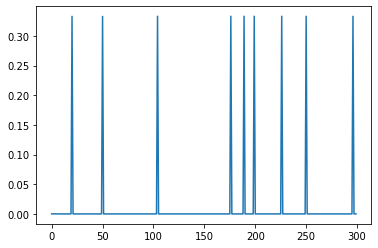

In [122]:
pd.Series(losses).plot()

In [123]:
a

tensor([[0.0001]], device='cuda:0', grad_fn=<SigmoidBackward>)

In [124]:
loss

tensor(1.4526e-08, device='cuda:0', grad_fn=<MeanBackward0>)

----------------------
label:  [0]


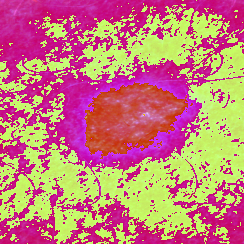

In [125]:
mds.display_sample(3)

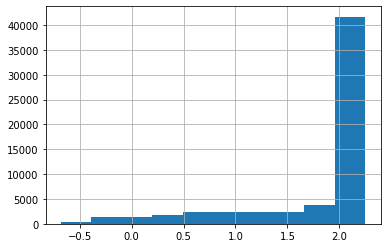

In [126]:
pd.Series(mds[1][0][0].view(-1,).to('cpu').numpy()).hist() # Are we normalizing with the correct values?

In [30]:
mdl